In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from src.const import AUDIO_PATH, MAIN_LABELS, BATCH_SIZE, VALIDATION_SPLIT, SEED
from src.data_loader import load_data

import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, OneOf, AddColorNoise

2024-04-14 18:38:10.661073: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 18:38:10.737489: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 18:38:11.041583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 18:38:12.214072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/telejkoi/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/telejkoi/.local/lib/python3.10/site-packages/tensorflow_i

In [2]:
train_ds, val_ds = load_data()

Found 64721 files belonging to 11 classes.
Using 51777 files for training.
Using 12944 files for validation.


2024-04-14 18:38:15.812914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 18:38:15.813325: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2024-04-14 18:38:18.362498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


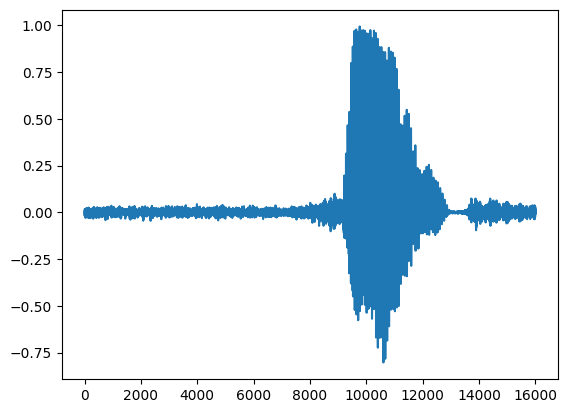

In [3]:
for X, y in train_ds.take(1):
    plt.plot(np.arange(0, len(X)), X.numpy())

In [4]:
audio = np.asarray(list(train_ds.map(lambda x, y: x)))
labels = np.asarray(list(train_ds.map(lambda x, y: y)))

2024-04-14 18:38:28.965054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-14 18:38:47.658324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
audio.shape, labels.shape

((51777, 16000), (51777,))

In [6]:
audio_main = audio[labels != 10]
labels_main = labels[labels != 10]

In [7]:
augment = OneOf(
    transforms= [
        AddColorNoise(min_f_decay=0, max_f_decay=0, p=1), # white noise
        AddColorNoise(min_f_decay=-3.01, max_f_decay=-3.01, p=1), # pink noise
        TimeStretch(min_rate=0.8, max_rate=0.95, leave_length_unchanged=True, p=1),
        TimeStretch(min_rate=1.05, max_rate=1.25, leave_length_unchanged=True, p=1),
        PitchShift(min_semitones=-5, max_semitones=-1, p=1),
        PitchShift(min_semitones=1, max_semitones=5, p=1),
        Shift(p=1, min_shift=-0.2, max_shift=-0.05, rollover=False),
        Shift(p=1, min_shift=0.05, max_shift=0.2, rollover=False)
    ]
)

In [8]:
audio_main_augmented = np.apply_along_axis(augment, -1, audio_main, sample_rate=16000)

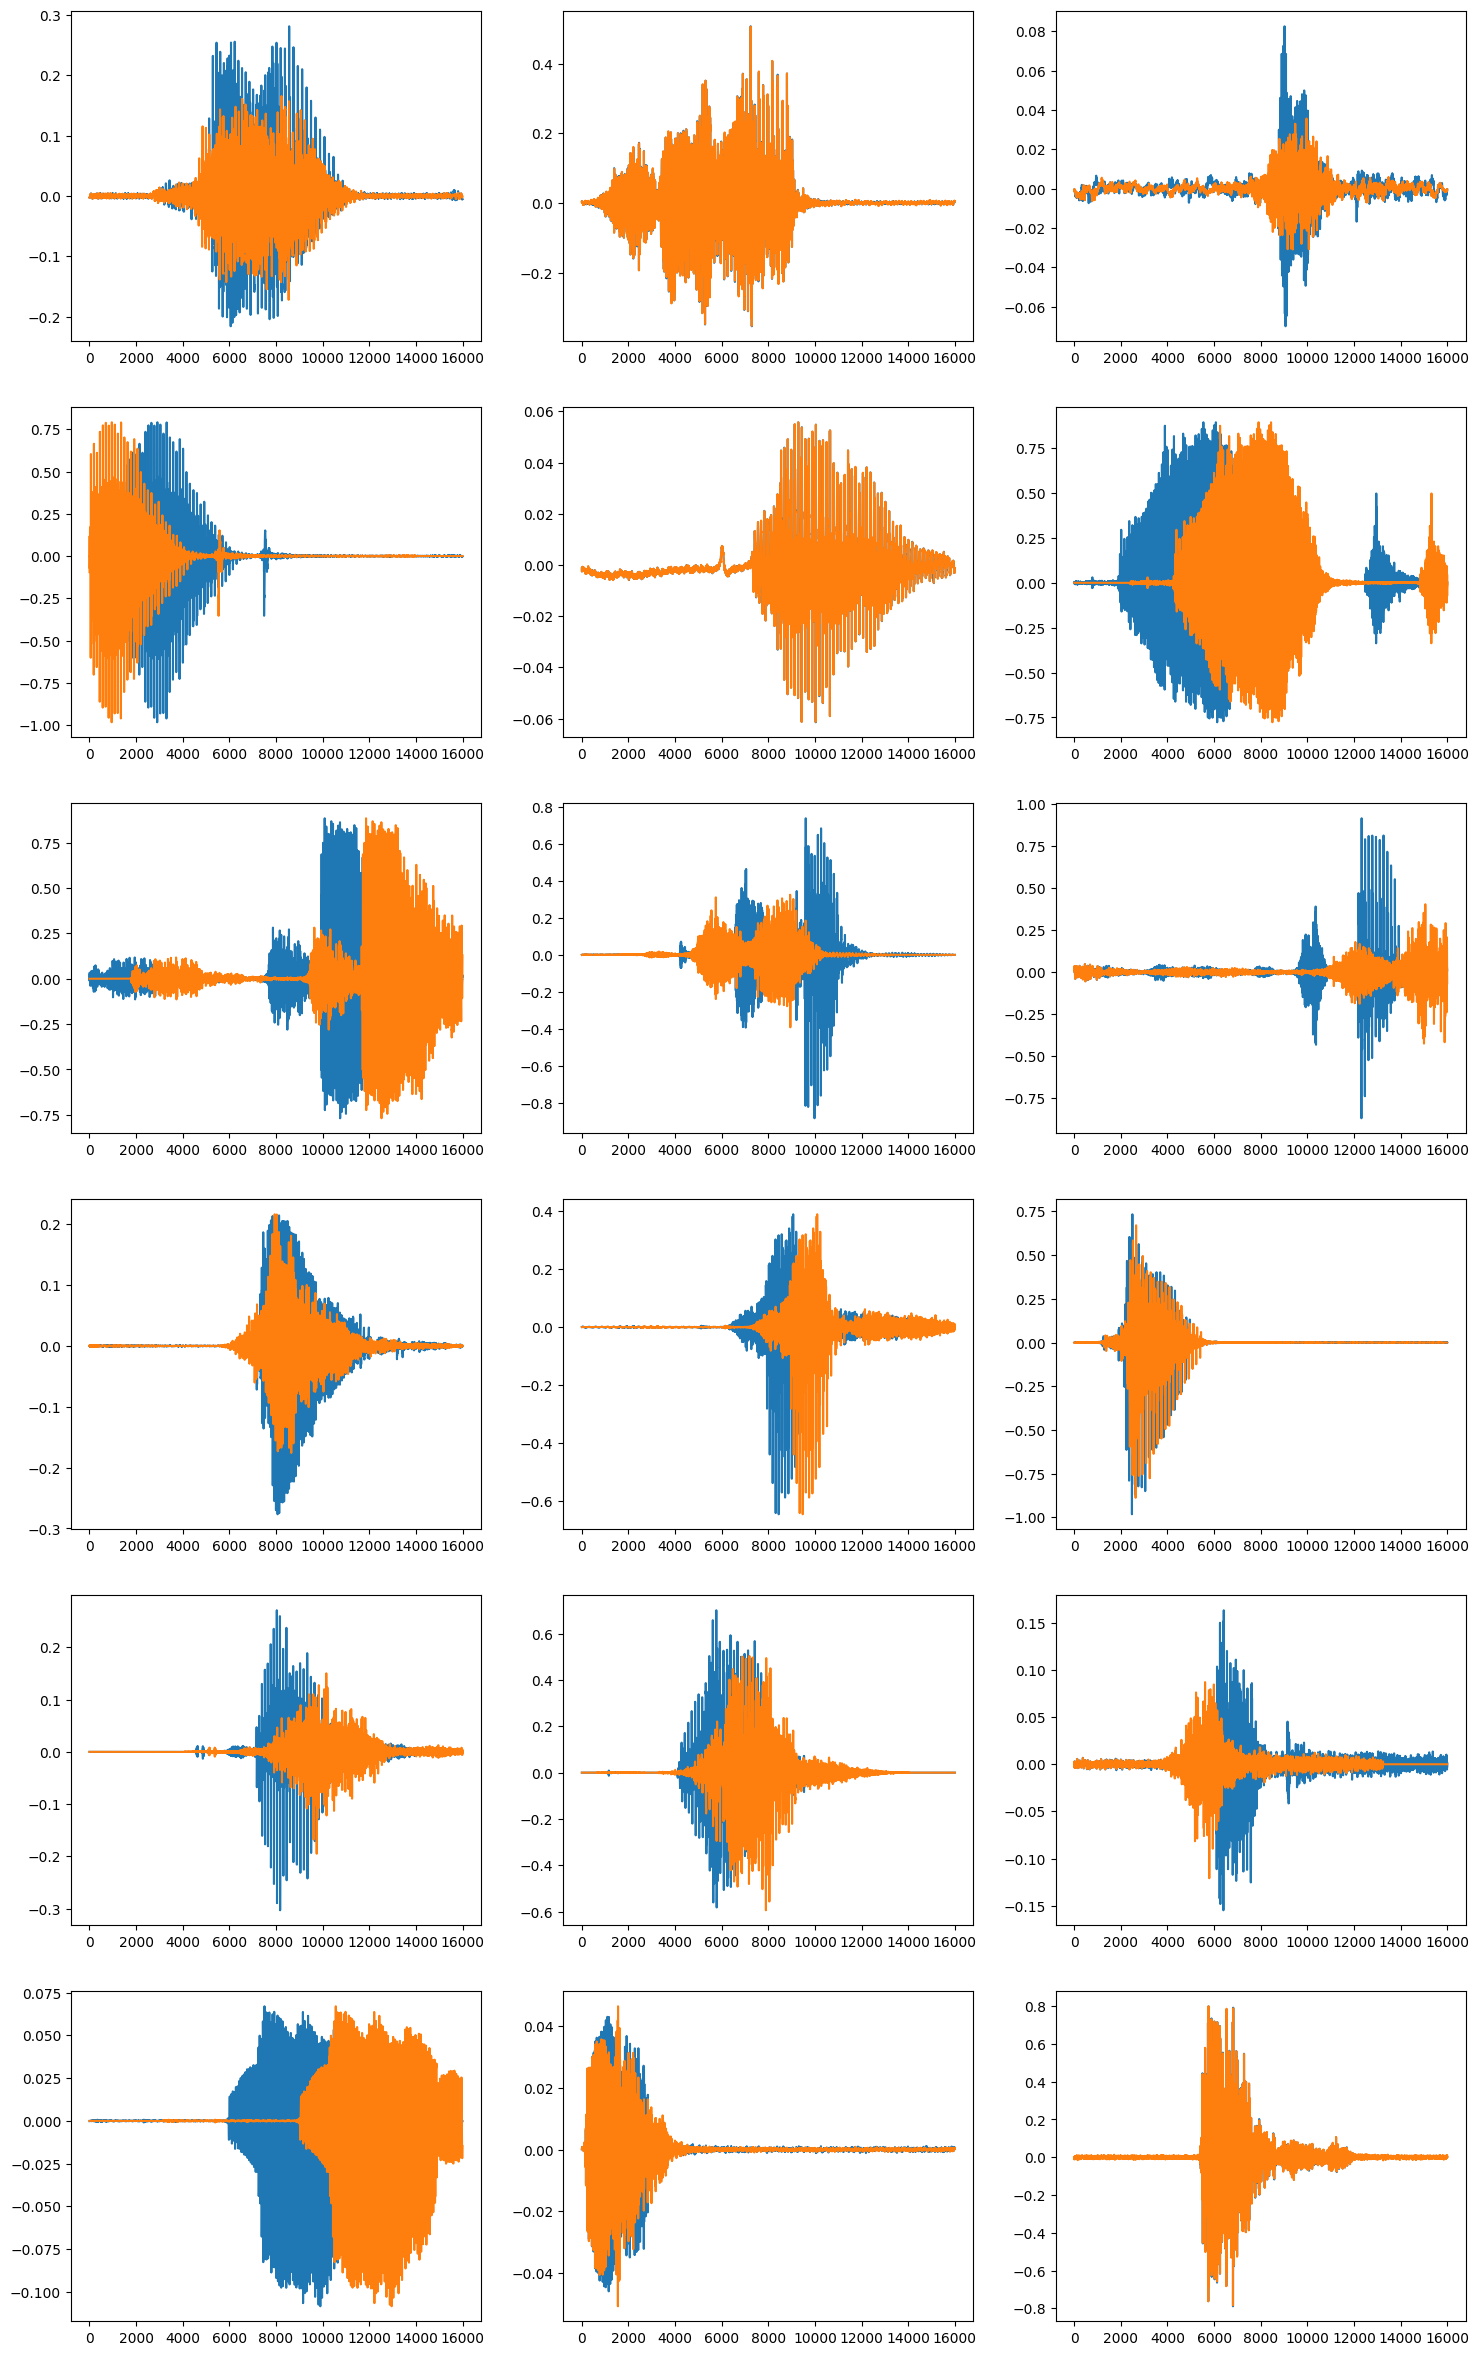

In [16]:
def single_plot(non_augmented, augmented, ax):
    """Plot ."""
    ax.plot(np.arange(0, len(non_augmented)), non_augmented)
    ax.plot(np.arange(0, len(non_augmented)), augmented)

non_augmented = audio_main[0:18]
fig, ax = plt.subplots(6, 3, figsize=(18, 30))
for i in range(18):
    single_plot(non_augmented[i], audio_main_augmented[i], ax[i//3, i%3])
plt.show()

In [21]:
audio.shape, labels.shape, audio_main_augmented.shape, labels_main.shape

audio_with_augmented = np.concatenate([audio, audio_main_augmented], axis=0)
audio_with_augmented.shape

: 

In [204]:
def preprocess_data_into_specs(ds):

  nfft=512
  window=512
  stride=256
  rate=16000
  mels=128
  fmin=0 
  fmax=8000
  top_db=80

  spect_ds = ds.map(
      map_func=lambda audio,label: (tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=stride), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  mel_spect_ds = spect_ds.map(
    map_func=lambda audio, label: (tfio.audio.melscale(audio, rate=rate, mels=mels, fmin=fmin, fmax=fmax), label),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  return mel_spect_ds.map(
      map_func=lambda audio,label: (tfio.audio.dbscale(audio, top_db=top_db), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
spec_train_ds = preprocess_data_into_specs(train_ds)
spec_val_ds = preprocess_data_into_specs(val_ds)

In [ ]:
for example_spec_audio, example_spec_labels in spec_train_ds.take(10):
    print(example_spec_audio.shape)

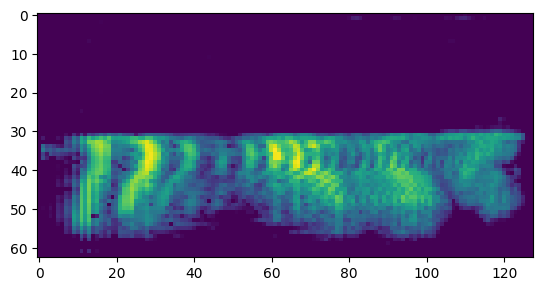

In [15]:
plt.imshow(example_spec_audio[39].numpy())
plt.show()

In [28]:
input_shape=(63,128)
model = tf.keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(11, activation='softmax'))
model.summary()

# layers.Bidirectional(layers.LSTM(20), merge_mode="sum")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,283 (555.79 KB)

 Trainable params: 142,283 (555.79 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
train_spectrogram_ds = spec_train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = spec_val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_spectrogram_ds, epochs=50, validation_data=val_spectrogram_ds)